In [46]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches # For custom legend
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Histogram notebook

In [47]:
data_sets = [
    "blobs", 
    "breast_cancer", 
    "wine", 
    "iris"
]

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

In [48]:
all_results = {}

methods_to_analyze = [
        'GradCF (eps=0) (sparsity fixed)',
        'CFAE',
        'NeighborSearch',
        "TGCF_DTC_Fidelity'"
    ] # Runs all methods when empty

for data_set in data_sets:
    methods = []
    base_path = f'./testdata/cfs/{data_set}'
    for p in os.listdir(base_path):
        with open(os.path.join(base_path, p), 'rb') as file:
            cf_obj = pickle.load(file)
            if cf_obj['name'] not in methods_to_analyze and methods_to_analyze != []:
                continue
            methods.append(cf_obj)

    methodNames = [m['name'] for m in methods]
    print('\n'.join(sorted(methodNames)))

    results = {}
    base_path = f'./testdata/eval/{data_set}'
    for m in methods:
        with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
            res = pickle.load(handle)
            results[m['name']] = res

    all_results[data_set] = results
    

CFAE
GradCF (eps=0) (sparsity fixed)
NeighborSearch
TGCF_DTC_Fidelity'
CFAE
GradCF (eps=0) (sparsity fixed)
NeighborSearch
TGCF_DTC_Fidelity'
CFAE
GradCF (eps=0) (sparsity fixed)
NeighborSearch
TGCF_DTC_Fidelity'
CFAE
GradCF (eps=0) (sparsity fixed)
NeighborSearch
TGCF_DTC_Fidelity'


In [49]:
def get_data(f, data_set, methods_to_analyze, all_results):

    dataset_results = []
    
    for data_set in data_sets:
        method_results = []
        for m in methods_to_analyze:
            res = all_results[data_set][m]
            result_x = [row[f] for row in res]

            all_x = []
            for i in range(len(result_x)):
                all_x.extend(result_x[i])
            method_results.append(all_x)
        dataset_results.append(method_results)
    return dataset_results
            
data = get_data(2, data_sets, methods_to_analyze, all_results)



In [50]:
print(data)

[[[np.float64(-1.954999941990787), np.float64(-1.6912053764091268), np.float64(-1.5906174569721636), np.float64(-1.7574373930295661), np.float64(-1.7803982084033674), np.float64(-1.6908350388658735), np.float64(-1.3577848870698115), np.float64(-1.355337191461508), np.float64(-1.32204730194546), np.float64(-2.515876713774155), np.float64(-1.8911742786983186), np.float64(-1.730382720455243), np.float64(-1.5912762029292253), np.float64(-1.7056579727228054), np.float64(-1.3561579699586026), np.float64(-1.5984805068209442), np.float64(-2.269712144085124), np.float64(-1.9928310697429232), np.float64(-1.691392192156733), np.float64(-1.357504312924752), np.float64(-1.8643951761756306), np.float64(-1.5717773911483097), np.float64(-1.6904547321070442), np.float64(-2.0356973206977904), np.float64(-1.6921456158089143), np.float64(-1.355087940276638), np.float64(-1.5897127867496708), np.float64(-1.6881888027479444), np.float64(-1.808200001942085), np.float64(-1.745851286390422), np.float64(-1.52653

## Plot

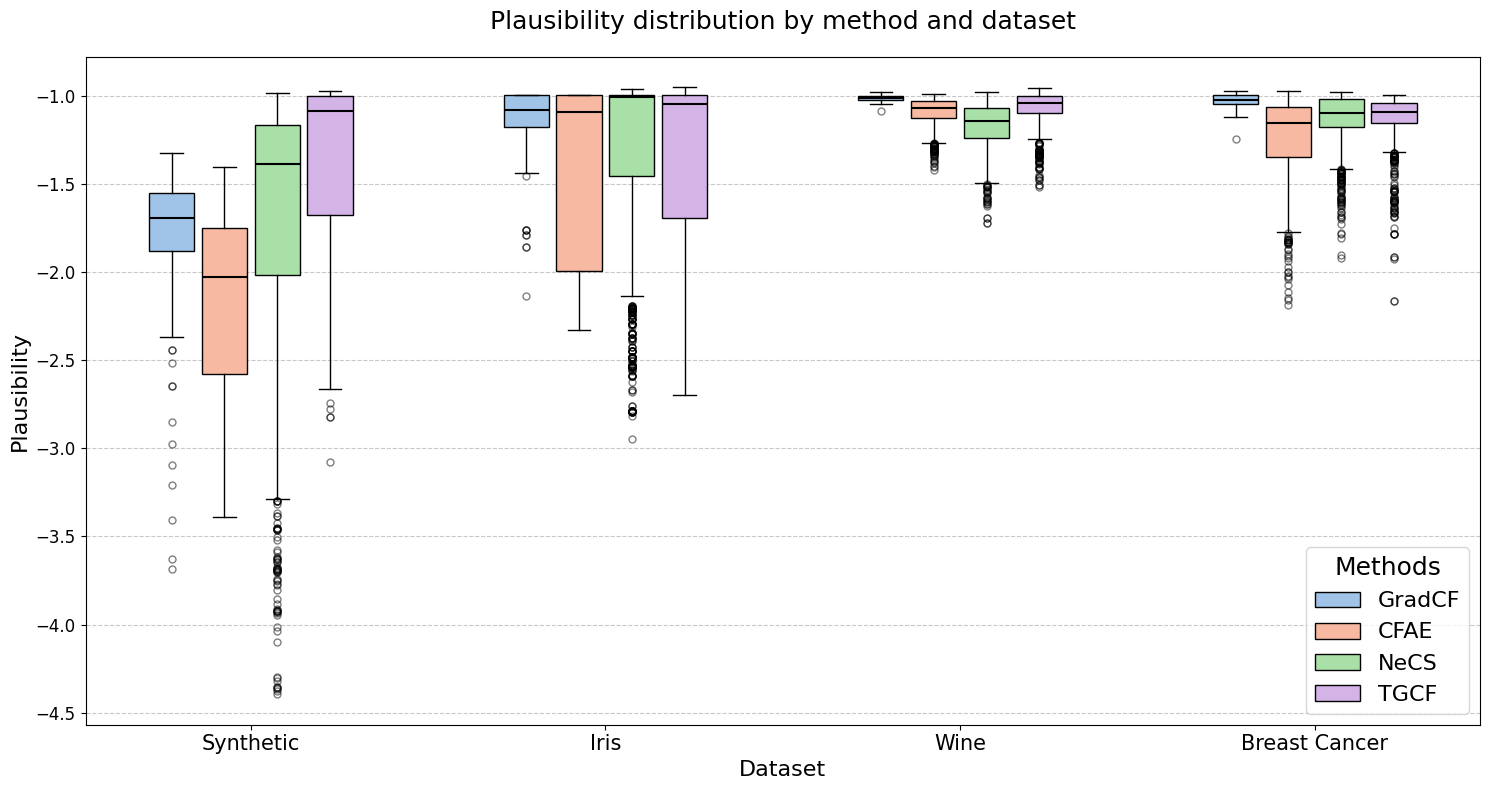

In [52]:
# 1. Define names and colors
dataset_names = ['Synthetic', 'Iris', 'Wine', 'Breast Cancer']
method_names = ['GradCF', 'CFAE', 'NeCS', 'TGCF']
# Using distinct colors for clarity
colors = ["#a0c4e7", "#f7b9a1", "#a8e0a8", "#d4b3e6"] # light blue, light orange, light green

# 2. Generate Sample Data
# For reproducibility

# following is gemini sample data for plotting
# np.random.seed(42)
# num_observations_per_box = 30  # Number of observations for each method on each dataset
# feature_values = {} # Dictionary to hold data: {method_name: [data_for_dataset1, data_for_dataset2, ...]}

# for m_idx, method_name in enumerate(method_names):
#     method_data_all_datasets = []
#     for d_idx in range(len(dataset_names)):
#         # Create slightly different distributions for visual distinction
#         base_value = d_idx * 5 + m_idx * 2
#         spread = 1.0 + d_idx * 0.5 + m_idx * 0.2
#         observations = np.random.normal(loc=base_value, scale=spread, size=num_observations_per_box)
#         method_data_all_datasets.append(observations)
#     feature_values[method_name] = method_data_all_datasets

feature_values = {
    method_names[0]: [ # GradCF
        data[0][0],  # Observations for Synthetic
        data[3][0],  # Observations for Iris
        data[2][0],  # Observations for Wine
        data[1][0],  # Observations for Breast Cancer
    ],
    method_names[1]: [ # Breast Cancer
        data[0][1],  # Observations for Synthetic
        data[3][1],  # Observations for Iris
        data[2][1],  # Observations for Wine
        data[1][1],  # Observations for Breast Cancer
    ],
    method_names[2]: [ # Wine
        data[0][2],  # Observations for Synthetic
        data[3][2],  # Observations for Iris
        data[2][2],  # Observations for Wine
        data[1][2],  # Observations for Breast Cancer
    ],
    method_names[3]: [ # Iris
        data[0][3],  # Observations for Synthetic
        data[3][3],  # Observations for Iris
        data[2][3],  # Observations for Wine
        data[1][3],  # Observations for Breast Cancer
    ]
}

# 3. Plot Parameters
n_datasets = len(dataset_names)
n_methods = len(method_names)

box_width = 0.18  # Width of a single boxplot
# Spacing between boxes of different methods within the same dataset group
spacing_between_methods_in_group = 0.03
# The space taken by one box center to the next box center within a group
step_for_methods = box_width + spacing_between_methods_in_group

# Calculate the total width occupied by all boxes in one group (for one dataset)
# This is (number of methods - 1) steps + width of one box
group_width_occupied_by_boxes = (n_methods - 1) * step_for_methods + box_width

# Gap between the last box of one dataset group and the first box of the next dataset group
inter_group_gap = 0.6
# Distance from the center of one dataset group to the center of the next
distance_between_group_centers = group_width_occupied_by_boxes + inter_group_gap

# Calculate the x-coordinates for the center of each dataset group
group_centers = np.arange(n_datasets) * distance_between_group_centers

# 4. Prepare Data for Plotting in the required flat format for boxplot positions
all_data_to_plot = [] # Flat list of data arrays for each box
actual_positions = [] # Corresponding positions for each box
box_plot_colors = []  # Corresponding colors for each box

for dataset_idx in range(n_datasets):
    current_group_center = group_centers[dataset_idx]
    for method_idx in range(n_methods):
        data_point = feature_values[method_names[method_idx]][dataset_idx]
        all_data_to_plot.append(data_point)

        # Calculate the offset of this method's box from the current group center
        # The term (n_methods - 1) / 2.0 centers the methods around the group_center
        position_offset_from_group_center = (method_idx - (n_methods - 1) / 2.0) * step_for_methods
        actual_positions.append(current_group_center + position_offset_from_group_center)
        box_plot_colors.append(colors[method_idx])

# 5. Create the Plot
fig, ax = plt.subplots(figsize=(15, 8)) # Adjust figsize as needed

# Create boxplots
# patch_artist=True is crucial for filling boxes with color
# medianprops customizes the median line
# manage_ticks=False lets us control ticks explicitly
bp = ax.boxplot(all_data_to_plot,
                positions=actual_positions,
                widths=box_width,
                patch_artist=True,
                medianprops=dict(color="black", linewidth=1.5),
                manage_ticks=False) # Important for custom positions

# Color the boxes
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(box_plot_colors[i])
    patch.set_edgecolor('black') # Add a black border to boxes

# Style whiskers, caps, and fliers (optional)
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1)
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5, markersize=5)


# 6. Labels, Title, and Legend
ax.set_ylabel('Plausibility', fontsize=16)
ax.set_xlabel('Dataset', fontsize=16)
ax.set_title('Plausibility distribution by method and dataset', fontsize=18, pad=20)

# Set x-axis ticks and labels to correspond to dataset group centers
ax.set_xticks(group_centers)
ax.set_xticklabels(dataset_names, fontsize=15)
ax.tick_params(axis='y', labelsize=12)


# Create custom legend handles
legend_elements = []
for i in range(n_methods):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], edgecolor='black', label=method_names[i]))

ax.legend(handles=legend_elements, title='Methods', loc='lower right', fontsize=16, title_fontsize=18)
# Add a grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust plot to prevent labels from overlapping
plt.show()